## Author: Joseph Bannon
## Date: 8/10/21

# **<center>Predicting survival of Titantic passengers</center>**

# Project overview and business understanding

The goal of this project is to predict survival of Titantic passengers using data obtained from the website Kaggle. The main evaluation metric in this case will be accuracy because that is what is used for scoring on Kaggle, but other evaluation metrics will be taken into account.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pandasql import sqldf
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")



# Data Collection 

The data used in this project was provided by the website Kaggle. The data set is origanlly provided as CSV files. These CSV files are imported into Kaggle as pandas dataframes. There are two files are provided, the train.csv file has all of the features and the target for model training. The test.csv file has all the features without the target, for testing on Kaggle.

In [2]:
train_display = pd.read_csv("train.csv")
test_display = pd.read_csv("test.csv")

In [3]:
train_display.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Explanation

The column **Survived** is the target, the other columns are all features.

**This is the explanation of the data provided by Kaggle:**
<table>
<tr><td>

| Variable    | Definition   | Key   |
| ----------- | ------------ | ----- |
| PassengerId | Unique identifier |       |
| Survived    | Survival     |0 = No<br> 1 = Yes |
| Pclass      | ticket class |1 = 1st<br> 2 = 2nd<br> 3 = 3rd|
| Sex         | Gender       | Male or Female |
| Age         | Age in years |       |

</td><td>

| Variable    | Definition   | Key   |
| ----------- | ------------ | ----- |
| sibsp       | # of siblings/ <br> spouses| |
| parch        | # of parents/ <br> children| |
| ticket      | Ticket number | |
| fare          | Passenger fare| |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg<br> Q = Queenstown<br> S = Southampten|

</td></tr> </table>


**Explanation of specific features**
- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower 


- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 


- sibsp: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)


- parch: The dataset defines family relations in this way...
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them.

### Display vs Modeling 

The target column for the data is **Survived** so it is removed from the **X_model_train**, the column is then given to **y_model_train** for modeling. The display and model dataframes will be modified in different way to achieve the goals of graphing data and creating an accurate model. 

For practical reasons I ran this code later in the notebook.

In [4]:
"""
X_model_train = train_display.drop(columns=["Survived"])
X_model_test = test_display

y_model_train = train_display[["Survived"]]
y_model_train = np.ravel(y_model_train.to_numpy()) 
"""

'\nX_model_train = train_display.drop(columns=["Survived"])\nX_model_test = test_display\n\ny_model_train = train_display[["Survived"]]\ny_model_train = np.ravel(y_model_train.to_numpy()) \n'

# Data Preperation

This stage of the project is data preperation. I will be looking at the raw data from the Kaggle data set and be making modifications to the data before further exploration. This includes replacing null values, modifying data to a suitable format and removing irrelevant data features.

In [5]:
train_display.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_display.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Replacing Null values

In [7]:
print("Titanic Data set total elements:", len(train_display.index))
print("Non Zero Null Values List:")
train_display.isnull().sum(axis = 0).loc[train_display.isnull().sum(axis = 0)!=0]

Titanic Data set total elements: 891
Non Zero Null Values List:


Age         177
Cabin       687
Embarked      2
dtype: int64

As you can see the only features with null values are **Age**, **Cabin** and **Embarked**. **Embarked** is only missing 2 out of 891  items so the most common element can be used to replace that feature without changing the data set.

**Age** and **Cabin** are missing quite a few of entries, so adding in only the mean or most common value will skew the data. For this case, seperate catagories for Nan values are created (Age is *-100*, Cabin is *"Other"*).

In [8]:
train_display[["Cabin"]] = train_display[["Cabin"]].replace(np.nan,"Other")
train_display[["Age"]] = train_display[["Age"]].replace(np.nan,-20)
train_display[["Embarked"]] = train_display[["Embarked"]].replace(np.nan,"S")

test_display[["Cabin"]] = test_display[["Cabin"]].replace(np.nan,"Other")
test_display[["Age"]] = test_display[["Age"]].replace(np.nan,-20)
test_display[["Embarked"]] = test_display[["Embarked"]].replace(np.nan,"S")

In [9]:
print("Null Values List:")
train_display.isnull().sum(axis = 0)

Null Values List:


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Now all there are no NaN vlaues in the data set.

### Modifying data type

The features **Pclass**,**Parch**, **SibSp** are represent by integers. Inorder to graph the features as catagorical data, this data is then converted to the string data type.

In [10]:
train_display[["Pclass"]] = train_display["Pclass"].apply(lambda row: str(row))
train_display[["Parch"]] = train_display["Parch"].apply(lambda row: str(row))
train_display[["SibSp"]] = train_display["SibSp"].apply(lambda row: str(row))

test_display[["Pclass"]] = test_display["Pclass"].apply(lambda row: str(row))
test_display[["Parch"]] = test_display["Parch"].apply(lambda row: str(row))
test_display[["SibSp"]] = test_display["SibSp"].apply(lambda row: str(row))

In [11]:
train_display.dtypes.loc[["Pclass","SibSp","Parch"]]

Pclass    object
SibSp     object
Parch     object
dtype: object

### Modifying data for further exploration

The Cabin data set gives the individual room data, but because there are so many different rooms its impossible to learning anything. Inorder to change the data to a form of catagorical data that can be used to train a model, I substring the first letter of each cabin and grouped them together

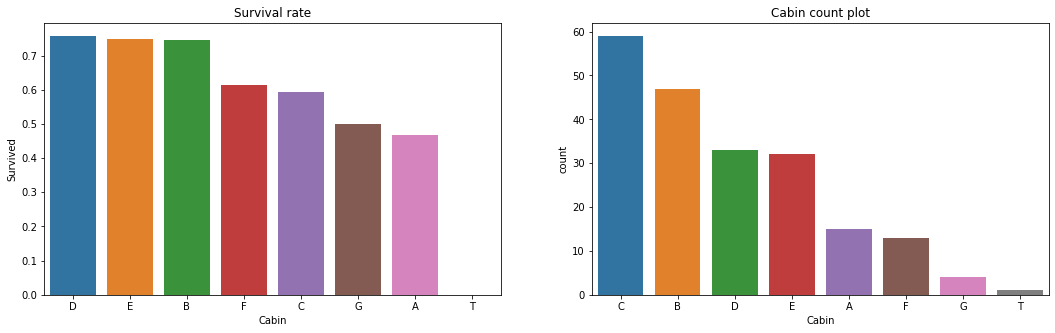

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
cabin_letter = train_display.loc[train_display["Cabin"]!="Other",["Cabin","Survived"]]
cabin_letter["Cabin"] = cabin_letter["Cabin"].str.slice(stop=1)
graph = cabin_letter.groupby("Cabin").mean()
graph.reset_index(inplace=True)

graph.sort_values(by="Survived", ascending=False, inplace=True)
sns.barplot(ax=axes[0],x="Cabin", y="Survived", data = graph)
sns.countplot(ax=axes[1],x="Cabin", data=cabin_letter, order = cabin_letter["Cabin"].value_counts().index)
axes[0].set_title("Survival rate")
axes[1].set_title("Cabin count plot")


train_display["Cabin"] = cabin_letter["Cabin"].replace(np.nan,"Other")


## for test_display
cabin_letter_test = test_display.loc[test_display["Cabin"]!="Other"]
cabin_letter_test["Cabin"] = cabin_letter_test["Cabin"].str.slice(stop=1)
test_display["Cabin"] = cabin_letter_test["Cabin"].replace(np.nan,"Other")


The resulting bar graph data shows some differeneces in the survival rate with **Cabins: E, D, B**, having higher surival rates. However, looking at the count plot shows very low counts compared to total rows of data, especailly **Cabins: T, G, A, F**.  **Cabins: C** has the most elements, but still not enough to draw any conclusions. In any case, it seems that **Cabins** doesn't have enough data to be accurate and doesn't show a clear trend. However, more data analysis is required.

### Removing irrelevent data

The features **Name**, **Ticket** are irrelevant to this data set for two reasons. Firstly, they can't be transformed into catagorical variables. Secondly, they intuitively shouldn't have an impact on survival. For these reasons, they are removed from the model.

In [13]:
train_display.drop(columns=["Name","Ticket"], inplace = True)
test_display.drop(columns=["Name","Ticket"], inplace = True)

# Data Analysis

This stage of the project is data analysis. I will be using graphs and figures to explore the impact each feature has on survivability. Histograms/co are used to provide counts of the classes within each features. Also, bar charts are used to measure the average survival rates for each class in a feature. Futhermore, multiple features can be graphed in a single chart by using *hue* option in seaborn.

[Text(0.5, 0, 'Feature')]

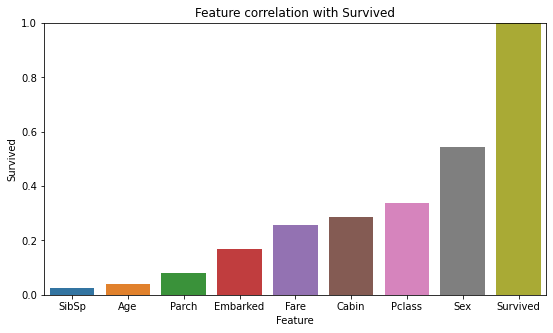

In [14]:
corr = train_display[["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Cabin","Embarked"]]
for column in corr.columns:
    if(column != "Survived" and column != "Age" and column != "Fare"):
        corr[[column]] = corr[[column]].astype('category')
        corr[[column]] = corr[[column]].apply(lambda x: x.cat.codes)
correlation = corr.corr()
correlation.reset_index(inplace=True)
correlation[["Survived"]] = correlation[["Survived"]].abs()

fig, axes = plt.subplots(figsize=(9, 5))

a_plot = sns.barplot(ax =axes,x="index", y="Survived", data=correlation.sort_values(by=['Survived']))
a_plot.set(ylim=(0, 1))
a_plot.set_title("Feature correlation with Survived")
a_plot.set(xlabel='Feature')

Above is a plot of the Pandas correlation matrix of survival with all the features. This is an initial look at the which variables will impact **Survived** the most, **Sex** and **Pclass** having the most weight. However, more analysis is required.

## Single feature analysis

<AxesSubplot:title={'center':'Cabin'}, xlabel='Cabin', ylabel='count'>

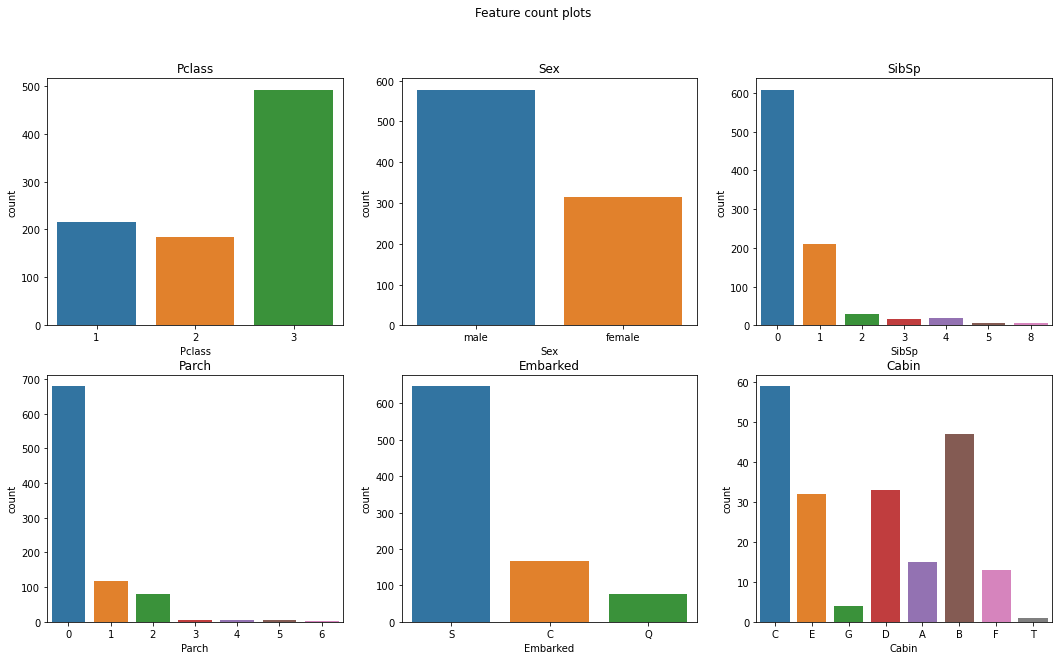

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle("Feature count plots")
axes[0,0].set_title("Pclass")
sns.countplot(ax=axes[0, 0],x="Pclass", data=train_display.sort_values(by=['Pclass']))
axes[0,1].set_title("Sex")
sns.countplot(ax=axes[0, 1],x="Sex", data=train_display)
axes[0,2].set_title("SibSp")
sns.countplot(ax=axes[0, 2],x="SibSp", data=train_display.sort_values(by=['SibSp']))
axes[1,0].set_title("Parch")
sns.countplot(ax=axes[1, 0],x="Parch",  data=train_display.sort_values(by=['Parch']))
axes[1,1].set_title("Embarked")
sns.countplot(ax=axes[1, 1],x="Embarked", data=train_display)
axes[1,2].set_title("Cabin")
sns.countplot(ax=axes[1, 2],x="Cabin", data=train_display.loc[train_display["Cabin"]!="Other"])

[(0.0, 1.0)]

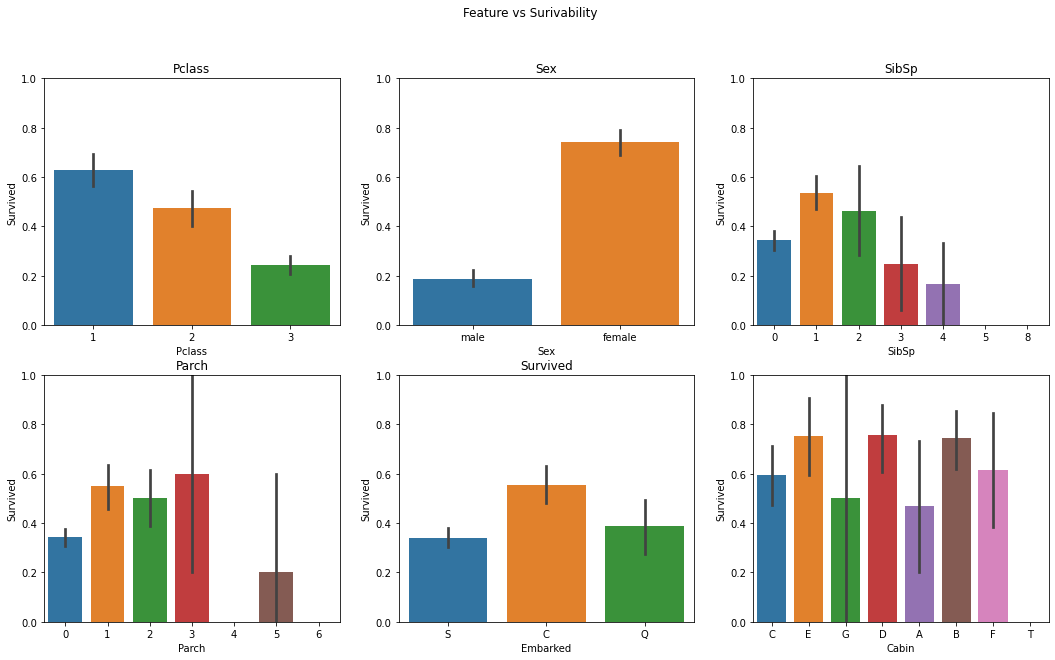

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle("Feature vs Surivability")

axes[0,0].set_title("Pclass")
a_plot = sns.barplot(ax=axes[0, 0],x="Pclass", y="Survived", data=train_display.sort_values(by=['Pclass']))
a_plot.set(ylim=(0, 1))

axes[0,1].set_title("Sex")
a_plot = sns.barplot(ax=axes[0, 1],x="Sex", y="Survived", data=train_display)
a_plot.set(ylim=(0, 1))

axes[0,2].set_title("SibSp")
a_plot = sns.barplot(ax=axes[0, 2],x="SibSp", y="Survived", data=train_display.sort_values(by=['SibSp']))
a_plot.set(ylim=(0, 1))

axes[1,0].set_title("Parch")
a_plot = sns.barplot(ax=axes[1, 0],x="Parch", y="Survived", data=train_display.sort_values(by=['Parch']))
a_plot.set(ylim=(0, 1))

axes[1,1].set_title("Embarked")
a_plot = sns.barplot(ax=axes[1, 1],x="Embarked", y="Survived", data=train_display)
a_plot.set(ylim=(0, 1))

axes[1,1].set_title("Survived")
a_plot = sns.barplot(ax=axes[1, 2], x="Cabin",y="Survived", data=train_display.loc[train_display["Cabin"]!="Other"])
a_plot.set(ylim=(0, 1))


Above are count plots and bar charts of the catagorical features of the data set. Intially it seems that **Pclass** and **Sex** are the features that have the most impact on **Surivial**. Looking at the count plots, these features have high amount of data for all the classes (> 200), supporting the idea the trends are accurate. 

The **Embarked** feature also shows a trend for surival rates, but the majority of the data is in the *Q* class. **SibSp** and **Parch** have show some differences between classes, but the trends seem to be inclusive and the most of the data is in the *0* class for both.

**Trends for Age**

Text(0.5, 1.0, 'Count plot')

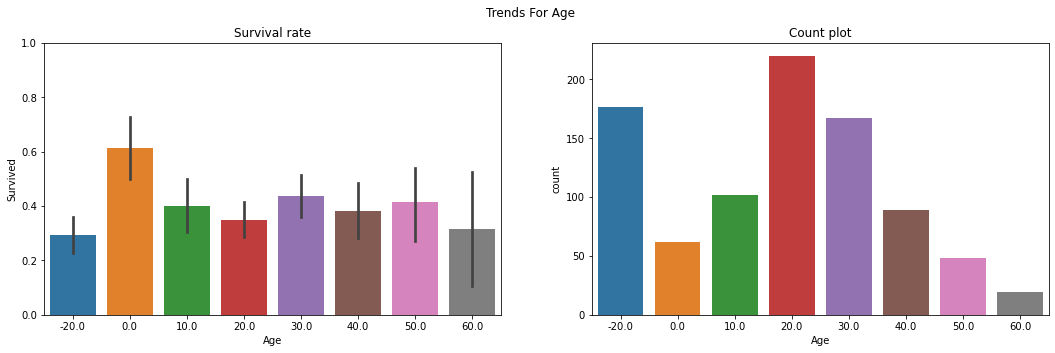

In [17]:
fig, axes = plt.subplots(1,2,figsize=(18, 5))
fig.suptitle("Trends For Age")

X_age_binned = train_display.loc[train_display["Age"]<70]

X_age_binned["Age"] = X_age_binned["Age"] // 10 * 10

a_plot = sns.barplot(ax = axes[0], data=X_age_binned ,x= "Age",y= "Survived")
a_plot.set(ylim=(0, 1))
a_plot.set_title("Survival rate")

a1_plot = sns.countplot(ax = axes[1], data=X_age_binned, x= "Age")
a1_plot.set_title("Count plot")


The graphs above shows **Age** in bins (0 - 19, 10 - 19, ... ). There seems to be difference in **Survival** rates in ages for group 0-9, but other than that age doesn't seem to have much of an impact. Furthermore, the number of elements in the class 0-9 is relatively small compared to the data set. 

Another observation is that the NaN values have a slightly lower survival rate compared to the other ages, but not enough to draw a solid conclusion.

**Trends with Fare**

Text(0.5, 1.0, 'Count Plot')

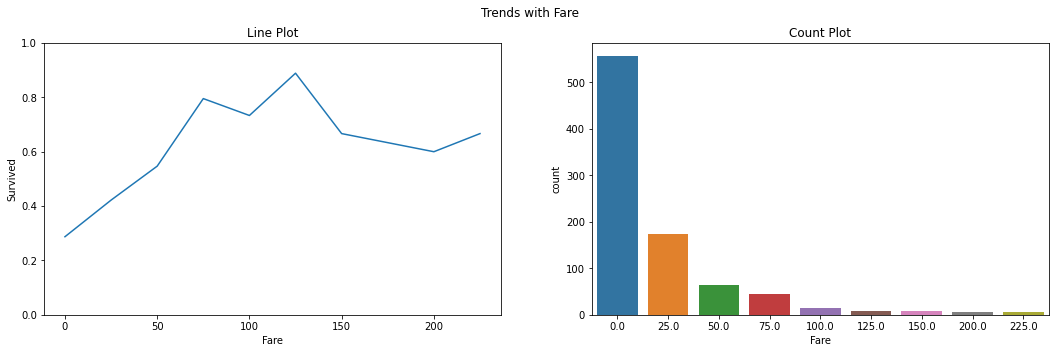

In [18]:
fig, axes = plt.subplots(1,2, figsize=(18, 5))
fig.suptitle("Trends with Fare")

X_fare_binned = train_display.loc[train_display["Fare"]<=250]
X_fare_binned["Fare"] = X_fare_binned["Fare"] // 25 * 25
a_plot = sns.lineplot(data=X_fare_binned,x= "Fare", y= "Survived", ax=axes[0],ci = None)
a_plot.set(ylim=(0, 1))
a_plot.set_title("Line Plot")

a1_plot = sns.countplot(data=X_fare_binned,x= "Fare", ax=axes[1])
a1_plot.set_title("Count Plot")


The graphs above shows **Fare** in bins (0 - 24, 25 - 50, ... ) excluding outliers. There seems to be a lose trend upwards trend in **Surival** as **Fare** increases. However, the vast majority of the data is less than 25, so there is difficulty identifying any trends in the higher numbers of fare.

Text(0.5, 1.0, 'Line plot of Fare less than 150')

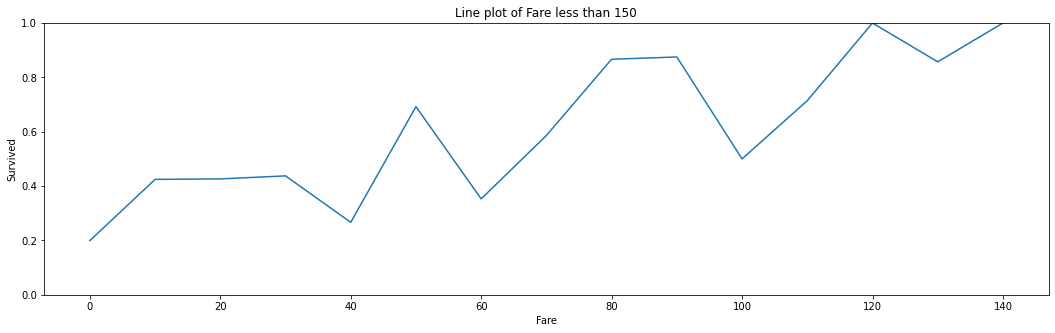

In [19]:
fig, axes = plt.subplots(figsize=(18, 5))

fare_100 = train_display.loc[train_display["Fare"]<150]    
fare_100["Fare"] = fare_100["Fare"] // 10 * 10
#replace with bins
a_plot = sns.lineplot(data=fare_100,x= "Fare", y= "Survived", ax=axes,ci = None)
a_plot.set(ylim=(0, 1))
a_plot.set_title("Line plot of Fare less than 150")



The graphs above shows **Fare** in bins (0 - 9, 10 - 19, ... ) excluding outliers. Again ther is a lose  trend upwards trend in **Surival** as **Fare** increases.

Text(0.5, 1.0, 'Count Plot')

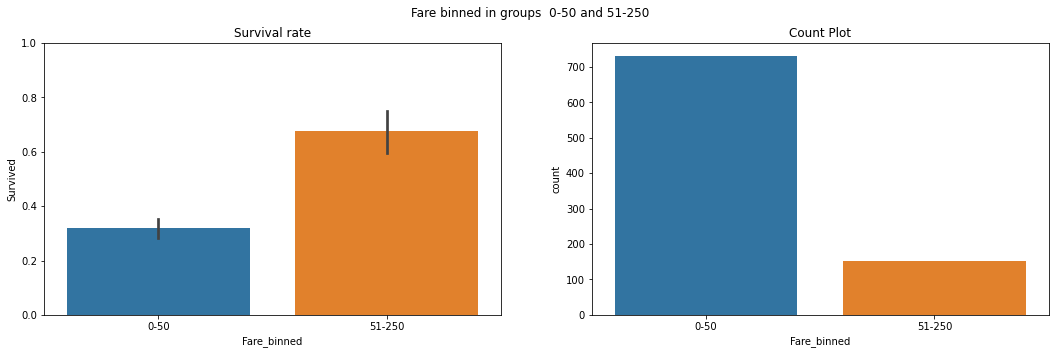

In [20]:
fig, axes = plt.subplots(1,2, figsize=(18, 5))
fig.suptitle("Fare binned in groups  0-50 and 51-250")

fare_50 = train_display.loc[train_display["Fare"]<=250]
fare_50["Fare_binned"] = fare_50["Fare"] <= 50
a_plot = sns.barplot(data=fare_50, order=[True,False],x= "Fare_binned", y= "Survived", ax=axes[0])
a_plot.set(ylim=(0, 1))
a_plot.set_xticklabels(["0-50","51-250"])
a_plot.set_title("Survival rate")

a1_plot = sns.countplot(data=fare_50, order=[True,False],x= "Fare_binned", ax=axes[1])
a1_plot.set_xticklabels(["0-50","51-250"])
a1_plot.set_title("Count Plot")


Looking **Fare** binned by greater than 50, less than 50, gives a much clearer picture of the how survivability relates to fare.

### Looking at graphs with two features

Previously, features were graphed individually against **Survived** to identify trends. In this section of the data analysis, I will break down each class in a feature by another feature using the *Hue* parameter in seabonr, inorder to obtain a better picture of how each feature **Survived**. The most influential features on **Survived** so far have been **Sex** and **Pclass**, so I will mostly be looking how these features interact with other catagories. 

**Trends with Pclass**

Text(0.5, 1.0, 'Pclass Survival rate divided by Sex')

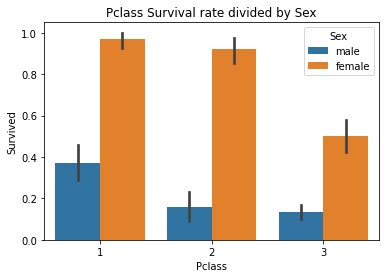

In [21]:
a_plot = sns.barplot(x="Pclass",y="Survived", data=train_display.sort_values(by=['Pclass']), hue="Sex")
a_plot.set_title("Pclass Survival rate divided by Sex")

The first figure shows the **Pclass** feature, split by **Sex**. The trends observed from the graph are similar to trends in **Sex** and **Pclass**, where "females" are more likely to survive then "men", and "1st class" are more likely to survive then "3rd class". Intrestingly though, "2nd class males" are as likely to survive as "3rd class males" but "2nd class females" are as likely to survive as "1st class females". This interaction of features could prove useful in fine tuning the inputs to a model.

**Looking at trends with Embarked**

Text(0.5, 1.0, 'Embarked divided by Pclass count plot')

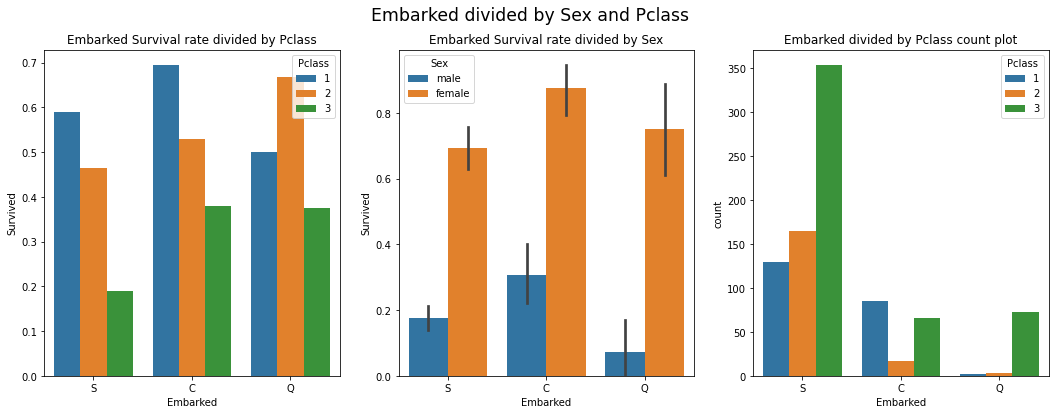

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Embarked divided by Sex and Pclass", size="xx-large")

a_plot = sns.barplot(ax=axes[0],x="Embarked",y="Survived", data=train_display.sort_values(by=['Pclass']), hue="Pclass", ci = None)
a_plot.set_title("Embarked Survival rate divided by Pclass")

a1_plot = sns.barplot(ax=axes[1],x="Embarked",y="Survived", data=train_display, hue="Sex")
a1_plot.set_title("Embarked Survival rate divided by Sex")

a2_plot = sns.countplot(ax = axes[2],x="Embarked", data=train_display.sort_values(by="Pclass"), hue="Pclass")
a2_plot.set_title("Embarked divided by Pclass count plot")


The first figure shows the **Embarked** feature, split by **Pclass**. The trends observed from the graph is that the vast majority of the influnece on **Survived** comes from the **Pclass** feature. The count plot supports this conclusion as the lowest **Survival rates** have more "3rd class" passengers and vis versa. The second figure shows the **Embarked** feature, split by **Sex**. The graph doesn't deviate from the trend, women have a higher survival rate then men.

**Looking at trends with SibSp and Parch**

<AxesSubplot:title={'center':'SibSp Survival rate divided by Pclass'}, xlabel='SibSp', ylabel='Survived'>

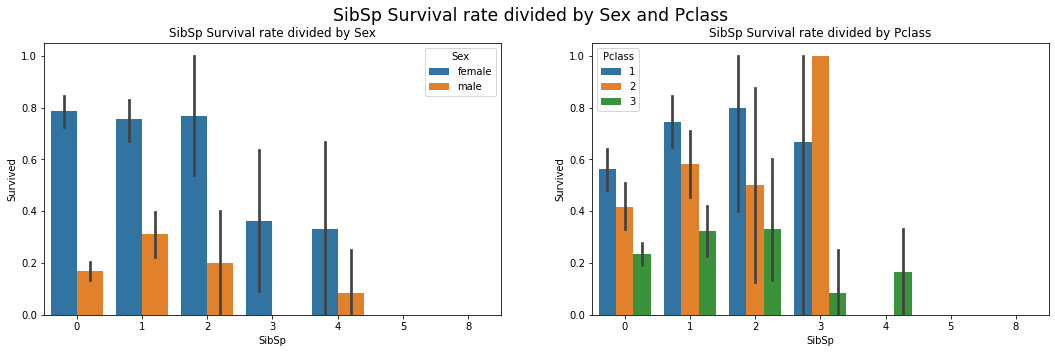

In [23]:
order = ["0","1","2","3","4","5","8"]

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle("SibSp Survival rate divided by Sex and Pclass", size="xx-large")

axes[0].set_title("SibSp Survival rate divided by Sex")
sns.barplot(ax=axes[0],x="SibSp", y="Survived", hue= "Sex", order = order, data=train_display.sort_values(by="Sex"))
axes[1].set_title("SibSp Survival rate divided by Pclass")
sns.barplot(ax=axes[1],x="SibSp", y="Survived", hue= "Pclass", order=order, data=train_display.sort_values(by="Pclass"))

<AxesSubplot:title={'center':'Parch Survival rate divided by Pclass'}, xlabel='Parch', ylabel='Survived'>

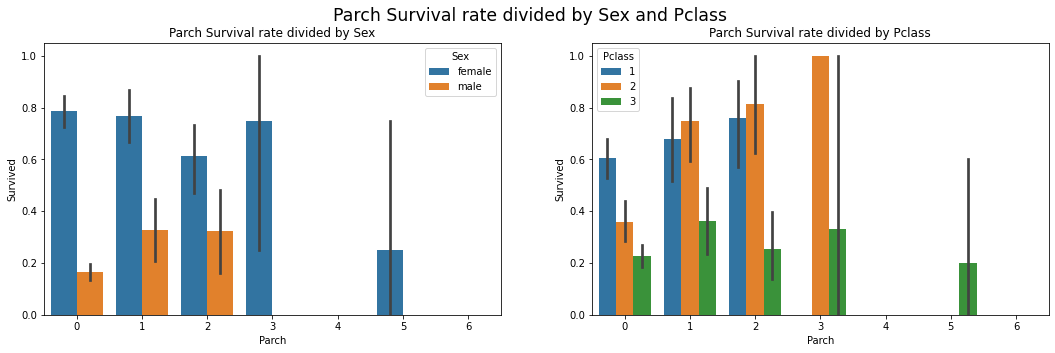

In [24]:
order = ["0","1","2","3","4","5","6"]

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle("Parch Survival rate divided by Sex and Pclass", size="xx-large")

axes[0].set_title("Parch Survival rate divided by Sex")
sns.barplot(ax=axes[0],x="Parch", y="Survived", hue= "Sex", order = order, data=train_display.sort_values(by="Sex"))
axes[1].set_title("Parch Survival rate divided by Pclass")
sns.barplot(ax=axes[1],x="Parch", y="Survived", hue= "Pclass", order = order, data=train_display.sort_values(by="Pclass"))

The features **Parch** and **SibSp** are each divided by **Sex** and **Pclass** and graphed against **Survival rate**. There doesn't seem to be any visable trends that from the graphs, they follow the general trends with survival rate and **Sex** and **Pclass**. This indicates that the features **Parch** and **SibSp** don't influence **Survived** in a indentifiable way.

**Trends with Age**

<AxesSubplot:title={'center':'Age Survival rate divided by Sex'}, xlabel='Age', ylabel='Survived'>

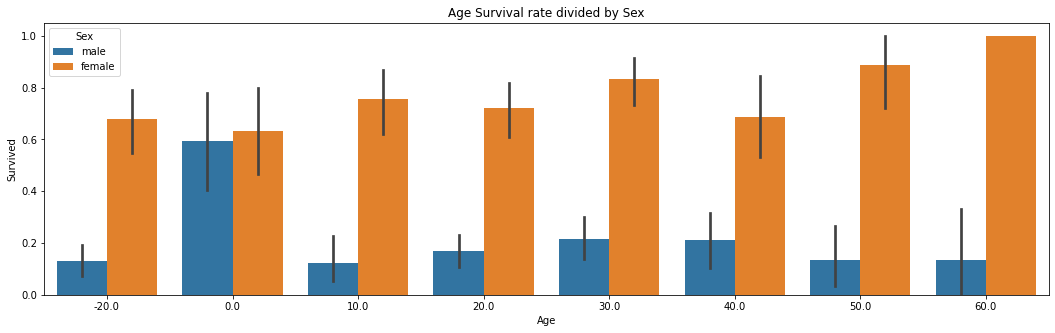

In [25]:
fig, axes = plt.subplots(figsize=(18, 5))
axes.set_title("Age Survival rate divided by Sex")
sns.barplot(data=X_age_binned,x= "Age",y= "Survived", hue = "Sex", ax = axes)

<AxesSubplot:title={'center':'Age Survival rate divided by Pclass'}, xlabel='Age', ylabel='Survived'>

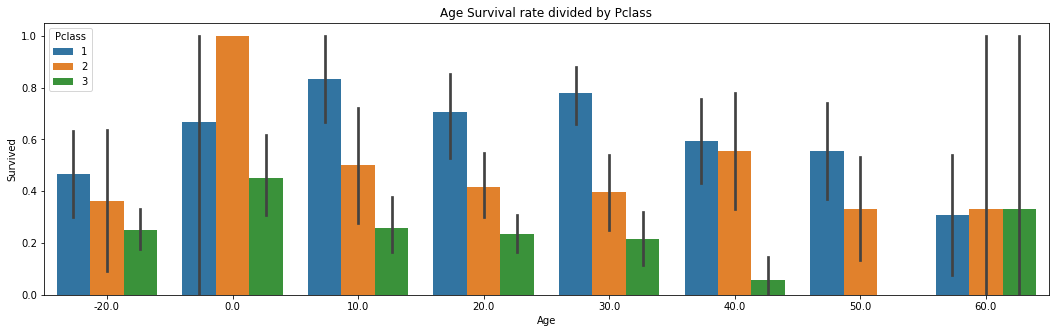

In [26]:
fig, axes = plt.subplots(figsize=(18, 5))
axes.set_title("Age Survival rate divided by Pclass")
#a1_plot.set_xticklabels(["0-50","51-250"])


sns.barplot(data=X_age_binned.sort_values("Pclass"),x= "Age",y= "Survived", hue = "Pclass", ax = axes)

<AxesSubplot:title={'center':'Age count plot divided by Pclass'}, xlabel='Age', ylabel='count'>

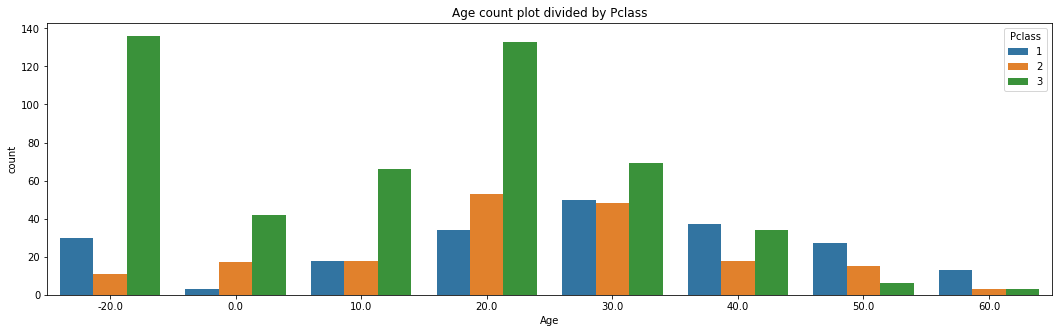

In [27]:
fig, axes = plt.subplots(figsize=(18, 5))
axes.set_title("Age count plot divided by Pclass")

sns.countplot(data=X_age_binned.sort_values("Pclass"),x= "Age", hue = "Pclass", ax = axes)

The figures above show the feature **Age** divided by **Sex** and **Pclass** graphed against **Survival rate**. The first figure follows the trends in **Sex** that "females" are more likely to survive then "males". However, the age group "0-9" seems to not follow this trend and has equal surival rate for both "females" and "males".

A similar pattern can be seen in the second figure. The age groups follow the trend for **Pclass**, expect for the "0-9" age group, which **Pclass** doesn't have a noticeable effect on. Although, there isn't enough data in the "0-9" to draw a solid conclusion.

The third figure supports the idea that small difference obsereved in **Age** are most likely to varying amount of "3rd class" passenger. It seems that the only effect of **Age** is due to the **Pclass** and **Sex** variables apart from the "0-9 age group".

**Trends with fare**

Text(0.5, 1.0, 'Survival rate divided by Pclass')

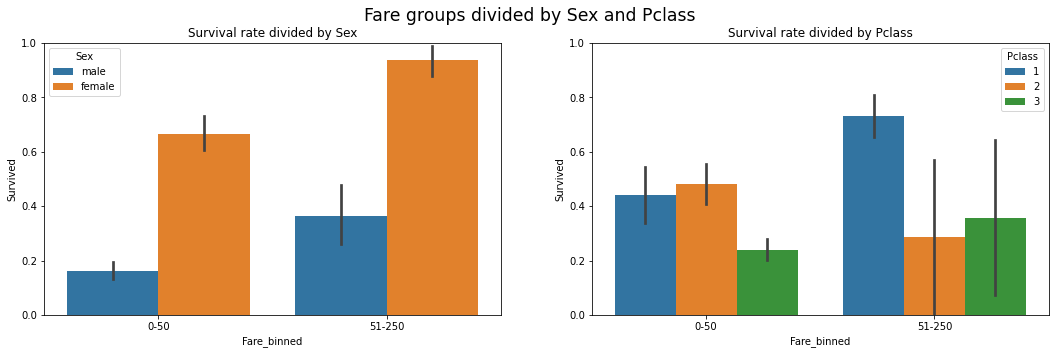

In [28]:
fig, axes = plt.subplots(1,2,figsize=(18, 5))
fig.suptitle("Fare groups divided by Sex and Pclass", size="xx-large")

a_plot = sns.barplot(data=fare_50, order=[True,False],x= "Fare_binned", y= "Survived", hue = "Sex", ax=axes[0])
a_plot.set(ylim=(0, 1))
a_plot.set_xticklabels(["0-50","51-250"])
a_plot.set_title("Survival rate divided by Sex")

fare_50.sort_values("Pclass", inplace=True)
a1_plot = sns.barplot(data=fare_50, order=[True,False],x= "Fare_binned", y= "Survived", hue = "Pclass",ax=axes[1])
a1_plot.set(ylim=(0, 1))
a1_plot.set_xticklabels(["0-50","51-250"])
a1_plot.set_title("Survival rate divided by Pclass")

The figures above show the feature **Fare** is divided by **Sex** and **Pclass**. There doesn't seem to be any visable trends that from the graphs, they follow the general trends with survival rate and **Sex** and **Pclass**. Interestingly, the **Survival rates** for "1st class" passengers are lower for "0-50"  than "51-250" **Fare**. This demonstrates that **Fare** influences **Survival rates** independent of **Pclass**.

# MODELING

This stage of the project is Modeling. I used Sklearn classification algorithms to build a model that accurately predicts survival of passengers. Inorder to accomplish this, goal I've tested multiple models, such as logistic regression, decision trees, Support vector machine. I also used grid search to adjust the hyper parameters of each.

This section will also build upon the Data Analysis section by representing the data in different ways based on conclusion from the Data Analysis. Examples include using OneHotEncoding for features, treating continous features as catagorical features and using feature selection.

Note: I use the X_model data frames for modeling and testing.

In [29]:
X_model_train = train_display.drop(columns=["Survived","PassengerId"])
display(train_display)
X_model_test = test_display.drop(columns=["PassengerId"])

y_model_train = train_display[["Survived"]]
y_model_train = np.ravel(y_model_train.to_numpy())

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,NaN,S
887,888,1,1,female,19.0,0,0,30.0000,B,S
888,889,0,3,female,-20.0,1,2,23.4500,NaN,S
889,890,1,1,male,26.0,0,0,30.0000,C,C


### Data preprocessing

The data analysis revealed that the age has very little affect on survival rate apart from the "0-9 age group." To limit the overfitting of data, I am transforming age into a catagorical variable of "0-9 age group" and not "0-9 age group."

In [30]:
X_model_train["Age"] = X_model_train["Age"].apply(lambda x: x >=0 and x < 9)
X_model_test["Age"] = X_model_test["Age"].apply(lambda x: x >=0 and x < 9)

I will also be using the Standard Scalar on **Fare** in an effort to make the feature have a more noticable effect on **Survived**. The graph bellow shows the results.

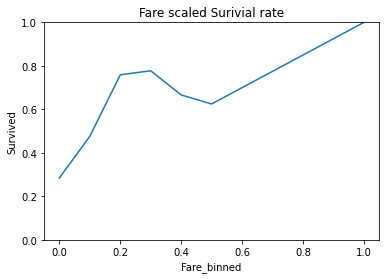

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

fare_nparr = X_model_train["Fare"].to_numpy().reshape(-1,1)

fare_scaled_arr = scaler.fit_transform(fare_nparr) 
fare_scaled = pd.DataFrame(fare_scaled_arr, columns = ['Fare'])

fare_scaled["Survived"] = train_display["Survived"]
fare_scaled["Fare_binned"] = round(fare_scaled["Fare"]/.1)*.1
a_plot = sns.lineplot(data=fare_scaled,x= "Fare_binned", y= "Survived",ci = None)
a_plot.set_title("Fare scaled Surivial rate")
a_plot.set(ylim=(0, 1))


X_model_train["Fare"] = fare_scaled["Fare"]

fare_nparr_test = X_model_test["Fare"].to_numpy().reshape(-1,1)
fare_scaled_arr_test = scaler.transform(fare_nparr_test) 
fare_scaled_test = pd.DataFrame(fare_scaled_arr_test, columns = ['Fare'])
X_model_test["Fare"] = fare_scaled_test["Fare"]

### One Hot Encoding

In [32]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder

Sex_enc = OneHotEncoder(drop='if_binary').fit(X_model_train["Sex"].to_numpy().reshape(-1,1))
Sex_column = Sex_enc.transform(X_model_train["Sex"].to_numpy().reshape(-1,1)).toarray()
X_model_train = X_model_train.join(pd.DataFrame(Sex_column, columns = ['Sex_enc']))
X_model_train.drop(columns = ["Sex"])

Sex_enc_test = OneHotEncoder(drop='if_binary').fit(X_model_test["Sex"].to_numpy().reshape(-1,1))
Sex_column_test = Sex_enc_test.transform(X_model_test["Sex"].to_numpy().reshape(-1,1)).toarray()
X_model_test = X_model_test.join(pd.DataFrame(Sex_column_test, columns = ['Sex_enc']))
X_model_test.drop(columns = ["Sex"])

print(" ")

In [33]:
X_model_train = pd.get_dummies(X_model_train)
X_model_test = pd.get_dummies(X_model_test)


display(X_model_train)

,Age,Fare,Sex_enc,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,False,0.014151,1.0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,False,0.139136,0.0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,False,0.015469,0.0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,False,0.103644,0.0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4,False,0.015713,1.0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,0.025374,1.0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
887,False,0.058556,0.0,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
888,False,0.045771,0.0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
889,False,0.058556,1.0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,0,1,0,0


# Feature Selection

For feature selection, I will be using the Recursive Feature Elimination, which takes every feature in the data set and eliminates the least important features recursively until there are a specified number of features left. This helps eliminate features that aren't relevant to the target and decreases the chances of overfitting.

A Random Forest Classifier will be used to determine feature importances. Also, grid search is used to determine hyperparameters and cross validation is used to get a better estimate of the overall accuracy of each model.

Note: the random state ensures the features are selected the same each time.

In [34]:
X_model_test["Fare"] = X_model_test["Fare"].replace(np.nan,X_model_test['Fare'].mean())
# bug in the code, one value of fare is NaN in the test data so I replaced it with the mean

In [35]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),n_features_to_select=15)
select.fit(X_model_train, y_model_train)

X_model_train_sel = select.transform(X_model_train)
X_model_test_sel = select.transform(X_model_test)

print("Number of features before in train data {}".format(X_model_train.shape[1]))
print("Number of selected features in train data {}".format(X_model_train_sel.shape[1]))
print("Number of selected features in test data {}".format(X_model_test_sel.shape[1]))


Number of features before in train data 33
Number of selected features in train data 30
Number of selected features in test data 30


### K Neighbor

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

k = [1,2,3,4,5,10,20,30,40,50]
param_grid = dict(n_neighbors=k) 

grid_search_k = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)

grid_search_k.fit(X_model_train,y_model_train)
print("Grid search parameters{}".format(grid_search_k.best_params_))
print("Grid search best training score: {:.5f}".format(grid_search_k.best_score_))


cv_scores_k = cross_val_score(grid_search_k,X_model_train,y_model_train, cv=4)

print("Test scores mean: {:.5f}".format(cv_scores_k.mean()))

Grid search parameters{'n_neighbors': 10}
Grid search best training score: 0.80696
Test scores mean: 0.79463


### Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression


solvers = ['liblinear', 'sag']
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = dict(solver=solvers,penalty=penalty,C=c_values) 

grid_search_lr = GridSearchCV(LogisticRegression(max_iter=100000), param_grid, cv=3)

grid_search_lr.fit(X_model_train,y_model_train)
print("Grid search parameters{}".format(grid_search_lr.best_params_))
print("Grid search best training score: {:.5f}".format(grid_search_lr.best_score_))

cv_scores_lr = cross_val_score(grid_search_lr,X_model_train,y_model_train, cv=4)

print("Test scores mean: {:.5f}".format(cv_scores_lr.mean()))


Grid search parameters{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Grid search best training score: 0.80247
Test scores mean: 0.80023


### Decision Tree

In [38]:
max_depth = [1,5,10,25]
n_estimators = [10,100,250]
max_leaf_nodes = [10,25,30,35,50]
param_grid = dict(max_depth=max_depth,n_estimators=n_estimators,max_leaf_nodes=max_leaf_nodes) 

grid_search_tree = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)

grid_search_tree.fit(X_model_train,y_model_train)
print("Grid search parameters {}".format(grid_search_tree.best_params_))
print("Grid search best training score: {:.5f}".format(grid_search_tree.best_score_))

cv_scores_tree = cross_val_score(grid_search_tree,X_model_train,y_model_train, cv=4)

print("Test scores mean: {:.5f}".format(cv_scores_tree.mean()))

Grid search parameters {'max_depth': 10, 'max_leaf_nodes': 30, 'n_estimators': 100}
Grid search best training score: 0.82267
Test scores mean: 0.81032


### Support Vector Machines

In [39]:
from sklearn.svm import SVC

C =  [0.01, 0.1, 1, 10]
gamma =  [0.01, 0.1, 1, 10]
kernel = ['rbf','linear']
param_grid = dict(C=C,gamma=gamma,kernel=kernel) 

grid_search_SVC = GridSearchCV(SVC(), param_grid, cv=3)

grid_search_SVC.fit(X_model_train,y_model_train)
print("Grid search parameters{}".format(grid_search_SVC.best_params_))
print("Grid search best training score: {:.5f}".format(grid_search_SVC.best_score_))


cv_scores_SVC = cross_val_score(grid_search_SVC,X_model_train,y_model_train, cv=4)

print("Test scores mean: {:.5f}".format(cv_scores_SVC.mean()))

Grid search parameters{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Grid search best training score: 0.81481
Test scores mean: 0.80922


# Model Evaluation and deployment

This section will compare the preformance of the models using different statistical techniques such as precision, recall and f1_score. I will also compare the models against a "programmed" model that chooses "females survive" and "males not surivived" for every sample. 

### Accuracy

The accuracy of each of the models is very simillar. This could be due to a number of reasons such as data being mostly noise, accuracy may be a poor statistic to use in this case, or just good preformance of each model. More evaluation metrics are required to chose a model for the final test variables.

### Programmed model

The following DecisionTree model was programmed to just predict based on the "Sex" feature as can be seen in feature importances. The model performs about as well as the majority of the other, much more complex models. This suggests that besides the **Sex** feature, the majority of the other data is noise and doesn't affect **Survived** in a consitent way.

In [40]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 1,random_state=0)
tree.fit(X_model_train, y_model_train)
programmed_score = tree.score(X_model_train, y_model_train)
print("Accuracy on training set: {:.5f}".format(programmed_score))
print("Feature importances:\n{}".format(tree.feature_importances_))

Accuracy on training set: 0.78676
Feature importances:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### F1_score

In this section, I will be looking at precision, recall and F1 score to evaluate the model. Precision and recall measure different statisitics that just accuracy, as they take into account false positives and false negative. F1 score is a means of combining the two numbers into one overall statistic.

In [41]:
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X_model_train, y_model_train, test_size=0.3, random_state=0)

In [43]:
f1_kn = cross_val_score(grid_search_k,X_model_train,y_model_train, scoring="f1", cv=3)
per_kn = cross_val_score(grid_search_k,X_model_train,y_model_train, scoring="precision", cv=3)
rec_kn = cross_val_score(grid_search_k,X_model_train,y_model_train, scoring="recall", cv=3)

print("F1 score for K Neighbor:", f1_kn.mean())
print("Percision score for K Neighbor:", per_kn.mean())
print("Recall score for K Neighbor:", rec_kn.mean())


F1 score for Support Vector Machine: 0.6925044870028688
Percision score for Support Vector Machine: 0.7884094430772035
Recall score for Support Vector Machine: 0.6228070175438597


In [44]:
f1_lr = cross_val_score(grid_search_lr,X_model_train,y_model_train, scoring="f1", cv=3)
per_lr = cross_val_score(grid_search_lr,X_model_train,y_model_train, scoring="precision", cv=3)
rec_lr = cross_val_score(grid_search_lr,X_model_train,y_model_train, scoring="recall", cv=3)

print("F1 score for Logistic Regression:", f1_lr.mean())
print("Percision score for Logistic Regression:", per_lr.mean())
print("Recall score for Logistic Regression:", rec_lr.mean())

F1 score for Support Vector Machine: 0.720827896047478
Percision score for Support Vector Machine: 0.7461776441770603
Recall score for Support Vector Machine: 0.6988304093567251


In [46]:
f1_tree = cross_val_score(grid_search_tree,X_model_train,y_model_train, scoring="f1", cv=3)
per_tree = cross_val_score(grid_search_tree,X_model_train,y_model_train, scoring="precision", cv=3)
rec_tree = cross_val_score(grid_search_tree,X_model_train,y_model_train, scoring="recall", cv=3)
print("F1 score for Random Forest:", f1_tree.mean())
print("Percision score for Random Forest:", per_tree.mean())
print("Recall score for Random Forest:", rec_tree.mean())


F1 score for Random Forest: 0.7366336621725756
Percision score for Random Forest: 0.8123383018862507
Recall score for Random Forest: 0.6403508771929824
F1 score for Random Forest: 0.6843354632018973
Percision score for Random Forest: 0.8043160949231458
Recall score for Random Forest: 0.6374269005847953


In [51]:
f1_SVC = cross_val_score(grid_search_SVC,X_model_train,y_model_train, scoring="f1", cv=3)
per_SVC = cross_val_score(grid_search_SVC,X_model_train,y_model_train, scoring="precision", cv=3)
rec_SVC = cross_val_score(grid_search_SVC,X_model_train,y_model_train, scoring="recall", cv=3)

print("F1 score for Support Vector Machine:", f1_SVC.mean())
print("Percision score for Support Vector Machine:", per_SVC.mean())
print("Recall score for Support Vector Machine:", rec_SVC.mean())

F1 score for Support Vector Machine: 0.7285967657798644
Percision score for Support Vector Machine: 0.7692237692237692
Recall score for Support Vector Machine: 0.6929824561403509


In [49]:
f1_dum = cross_val_score(tree,X_model_train,y_model_train, scoring="f1", cv=3)
per_dum = cross_val_score(tree,X_model_train,y_model_train, scoring="precision", cv=3)
rec_dum = cross_val_score(tree,X_model_train,y_model_train, scoring="recall", cv=3)

print("F1 score for Programmed Model:", f1_dum.mean())
print("Percision score for Programmed Model:", per_dum.mean())
print("Recall score for Programmed Model:", rec_dum.mean())

F1 score for Programmed Model: 0.7097017581322514
Percision score for Programmed Model: 0.7419406218144751
Recall score for Programmed Model: 0.6812865497076023


To summarize, the F1 score analysis resulted in a more complete picture than accuracy. The Random Forest had the best F1 scores with ".73" from the cross validation.

The Random Forest and Support Vector Machines had simillar accuracy scores and F1 scores, but different values for percision and accuracy. Comparing the precision, the precision for Random Forest was higher than the Support Vector Machines, meaning that the Random Forest had a lower False positive rate. 

However, the opposite trend occured with recall rates. The Support Vector Machines had a much higher recall than the Random Forest, meaning it had a lower false negative rate than the Random Forest.

Compared to the Programmed Model, the more complex models still don't have much better F1 scores indicating that the **Sex** feature is that the models can consitently learn from.

### Final Results

The model I am choosing is the Support Vector Machine model because it is both fast and accurate on the data set. The Random Forest Model is also an alternative, but its proccessing times make it less applicable to real world application.

In [53]:
prediction =  grid_search_SVC.predict(X_model_test)
output = pd.DataFrame({'PassengerId': test_display.PassengerId, 'Survived': prediction})
output.to_csv('my_submission.csv', index=False)

Results of test:  **0.779**

### Further additions

To do: add polynomial iteractions of features **Sex** and **Age**, bin **Parch** and **Sibsp** into "0" and "not 0"